In [12]:

from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score






In [13]:
# Backbone Network (Feature Extraction)
def backbone(input_shape):
    inputs = layers.Input(input_shape)
    # Simple backbone with conv layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return models.Model(inputs, x, name='backbone')


In [14]:
# Mask Head
def mask_head(features, num_classes, input_shape):
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(features)
    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(num_classes, (2, 2), strides=(2, 2), activation='softmax', padding='same')(x)
    return x


# Box Head (Simplified for demonstration)
def box_head(features):
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(features)
    x = layers.Flatten()(x)
    x = layers.Dense(4, activation='linear')(x)  # Outputs bounding box coordinates
    return x

In [15]:
# YOLACT-Like Model
def yolact_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    backbone_model = backbone(input_shape)
    features = backbone_model(inputs)

    mask_output = mask_head(features, num_classes, input_shape)
    box_output = box_head(features)

    return models.Model(inputs, [box_output, mask_output])




In [16]:
def load_data_coco(image_dir, annotation_file, input_size, num_classes):
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()

    images, masks = [], []
    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, input_size)

        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((input_size[0], input_size[1]), dtype=np.uint8)

        for ann in anns:
            mask = np.maximum(mask, cv2.resize(coco.annToMask(ann), input_size))

        images.append(img)
        masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks)
    masks = np.eye(num_classes)[masks]
    masks = masks.reshape(-1, input_size[0], input_size[1], num_classes)

    return images, masks

In [17]:


# Paths (Use Correct Paths)
train_image_dir = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train"
train_annotation_file =r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train.coco.json"
val_image_dir = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\val"
val_annotation_file =r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\val.coco.json"

# Parameters
input_shape = (128, 128, 3)
num_classes = 4

X_train, Y_train = load_data_coco(train_image_dir, train_annotation_file, (128, 128), num_classes)
X_val, Y_val = load_data_coco(val_image_dir, val_annotation_file, (128, 128), num_classes)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


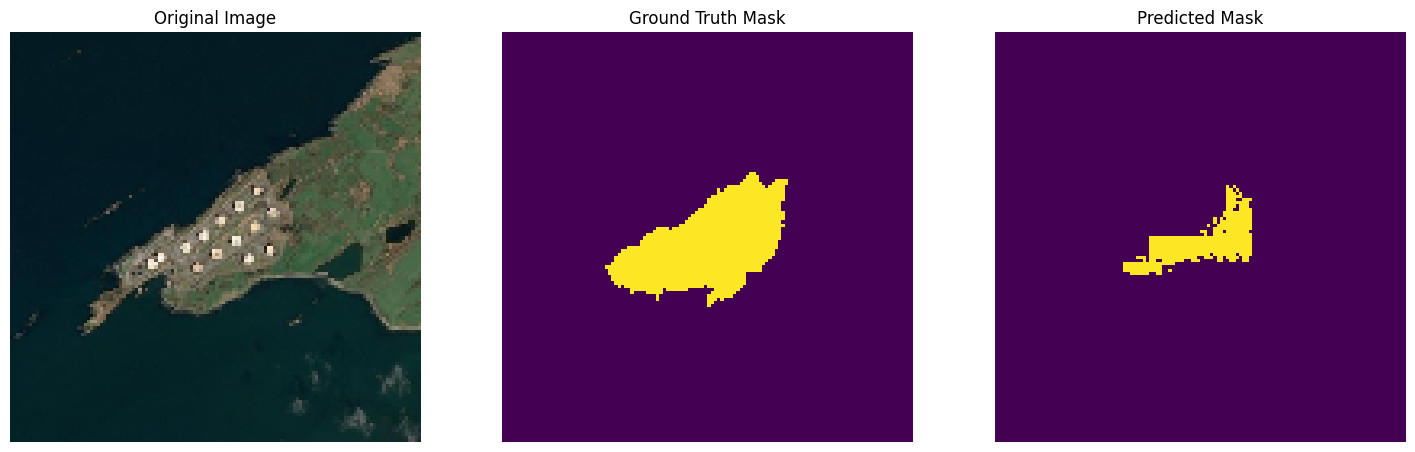

In [23]:
# Visualize Mask Predictions
sample_image = X_val[0]
true_mask = Y_val[0].argmax(axis=-1)
predicted_mask = model.predict(sample_image[np.newaxis, ...])[1][0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='viridis')
plt.title("Ground Truth Mask")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Make sure the values are integers
true_masks_flat = true_masks_flat.astype(int)
pred_masks_flat = pred_masks_flat.astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(true_masks_flat, pred_masks_flat, average='weighted')
recall = recall_score(true_masks_flat, pred_masks_flat, average='weighted')
f1 = f1_score(true_masks_flat, pred_masks_flat, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7994
Recall: 0.8334
F1 Score: 0.7859


In [3]:
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Backbone Network (Feature Extraction)
def backbone(input_shape):
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return models.Model(inputs, x, name='backbone')

# Mask Head
def mask_head(features, num_classes):
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(features)
    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(num_classes, (2, 2), strides=(2, 2), activation='softmax', padding='same')(x)
    return x

# Box Head (Simplified for demonstration)
def box_head(features):
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(features)
    x = layers.Flatten()(x)
    x = layers.Dense(4, activation='linear')(x)  # Outputs bounding box coordinates
    return x

# YOLACT-Like Model
def yolact_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    backbone_model = backbone(input_shape)
    features = backbone_model(inputs)

    mask_output = mask_head(features, num_classes)
    box_output = box_head(features)

    return models.Model(inputs, [box_output, mask_output])

# Load COCO Data
def load_data_coco(image_dir, annotation_file, input_size, num_classes):
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()

    images, masks = [], []
    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, input_size)

        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((input_size[0], input_size[1]), dtype=np.uint8)

        for ann in anns:
            mask = np.maximum(mask, cv2.resize(coco.annToMask(ann), input_size))

        images.append(img)
        masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks)
    masks = np.eye(num_classes)[masks]
    masks = masks.reshape(-1, input_size[0], input_size[1], num_classes)

    return images, masks

# Paths (Use Correct Paths)
train_image_dir = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train"
train_annotation_file = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train.coco.json"
val_image_dir = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\val"
val_annotation_file = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\val.coco.json"

# Parameters
input_shape = (128, 128, 3)
num_classes = 4

# Load Data
X_train, Y_train = load_data_coco(train_image_dir, train_annotation_file, (128, 128), num_classes)
X_val, Y_val = load_data_coco(val_image_dir, val_annotation_file, (128, 128), num_classes)

# Create Model
model = yolact_model(input_shape, num_classes)

# Compile Model
model.compile(
    optimizer='adam',
    loss={
        'dense_1': 'mse',  # Loss for bounding box regression
        'conv2d_transpose_5': 'categorical_crossentropy'  # Loss for mask segmentation
    },
    metrics={
        'dense_1': ['mse'],  # Metrics for bounding box regression
        'conv2d_transpose_5': ['accuracy']  # Metrics for mask segmentation
    }
)

# Train Model
model.fit(
    X_train,
    {
        'dense_1': Y_train,  # Output for bounding boxes
        'conv2d_transpose_5': Y_train  # Output for masks
    },
    validation_data=(
        X_val,
        {
            'dense_1': Y_val,
            'conv2d_transpose_5': Y_val
        }
    ),
    epochs=20,
    batch_size=16
)



# Evaluate and Visualize Results
sample_image = X_val[0]
true_mask = Y_val[0].argmax(axis=-1)
predicted_mask = model.predict(sample_image[np.newaxis, ...])[1][0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

# Metrics
y_true = true_mask.flatten()
y_pred = predicted_mask.flatten()
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")

# Visualization
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='viridis')
plt.title("Ground Truth Mask")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch 1/20


ValueError: Expected keys ListWrapper(['dense_2', 'conv2d_transpose_8']) in loss dict, but found loss.keys()=['dense_1', 'conv2d_transpose_5']

: 